Maastricht_University_logo.svg

# Information Retrieval and Text Mining Course
## Tutorial 07 — Information Extraction: Building Structured Representations from Text (Part 2)

**Author:** Jan Scholtes and Gijs Wijngaard

**Edition 2025-2026**

Department of Advanced Computer Sciences — Maastricht University

Welcome to Tutorial 07 on **Information Extraction**. In this tutorial, you will learn and practice several methods for extracting structured information from text. The topics covered are:

1. **Named Entity Recognition (NER) with NLTK** — traditional POS tagging, chunking, and entity extraction.
2. **BERT: Tokenizers and Embeddings** — understanding context-sensitive representations using the BERT Transformer architecture.
3. **Pre-trained BERT for NER** — using a HuggingFace pipeline with the `dslim/bert-base-NER` model.
4. **Fine-tuning BERT for NER** — training BERT on the CoNLL-2003 dataset.
5. **Entity Normalization and String Matching** — Levenshtein, Jaro-Winkler, Jaccard, and Soft TF-IDF.
6. **From Text to Knowledge Graphs** — extracting triples and building knowledge graphs with NetworkX.

At the end you will find the **Exercises** section with graded assignments.

> **Note:** This course is about Information Retrieval, Text Mining, and Conversational Search — not about programming skills. The code cells below are meant to show you *how* these methods work in practice using Python libraries. Focus on understanding the **concepts** and **results**.

## Library Installation

We install all required packages in a single cell. Run this cell once at the beginning of your session.

In [97]:
# Install required packages
import subprocess, sys

packages = ["svgling", "accelerate", "datasets", "seqeval", "evaluate", "python-Levenshtein", "networkx"]
for pkg in packages:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

print("All packages installed successfully.")

All packages installed successfully.


## Library Imports

All imports are grouped here so the notebook is easy to set up and run.

In [98]:
# Standard library
import os
import random
from collections import defaultdict
from pprint import pprint

# Data & visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# NLTK
import nltk
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)
nltk.download('maxent_ne_chunker', quiet=True)
nltk.download('maxent_ne_chunker_tab', quiet=True)
nltk.download('words', quiet=True)
from nltk import word_tokenize, pos_tag, sent_tokenize, ne_chunk, RegexpParser
from nltk.chunk import conlltags2tree, tree2conlltags
from nltk.tree import Tree

# Visualization for parse trees
import svgling

# PyTorch
import torch

# HuggingFace Transformers
from transformers import (
    BertTokenizer, BertTokenizerFast, BertModel,
    BertForSequenceClassification, BertForTokenClassification,
    AutoTokenizer, AutoModelForTokenClassification,
    Trainer, TrainingArguments, DataCollatorForTokenClassification,
    pipeline
)

# Datasets
from datasets import load_dataset

# Evaluation
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import evaluate

# String matching
import Levenshtein

# Knowledge graphs
import networkx as nx

# Reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

print("All libraries loaded successfully.")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

All libraries loaded successfully.
PyTorch version: 2.10.0+cpu
CUDA available: False


---
# 1. Named Entity Recognition with NLTK

Named Entity Recognition (NER) is the task of locating and classifying named entities in text into predefined categories such as **person names**, **organizations**, **locations**, **dates**, **medical codes**, etc.

**Information Extraction** aims to identify several types of structured elements from text:
- **Entities**: people, companies, locations, products, genes, etc.
- **Attributes**: properties of entities (age, title, address, etc.)
- **Facts**: relationships between entities (e.g., a person works for a company)
- **Events**: activities involving entities (e.g., a person travels to a location)
- **Concepts**: harder-to-define patterns with often ambiguous meanings

**Key challenges** include:
- Unknown words (dictionaries are never complete)
- Same words occurring as different entity types (e.g., "Apple" as company vs. fruit)
- Boundary problems (e.g., "City University of New York")
- Multiple textual forms for one entity (e.g., "Barack Obama", "B. Obama", "The President")
- Abbreviations (e.g., IBM, HP, WSJ)

State-of-the-art NER systems for English produce near-human performance (F-measure ~93% vs. ~97% for human annotators).

## 1.1 POS Tagging

Part-of-Speech (POS) tagging assigns a grammatical tag (noun, verb, adjective, etc.) to each word in a sentence. POS tags form the basis for many NER pipelines, since named entities are typically nouns or noun phrases.

In [99]:
# POS tagging with NLTK
sentence = "IRTM is an interesting course on Information Retrieval, Text Mining, and Conversational Search"
tokens = word_tokenize(sentence)
tagged = pos_tag(tokens)
print(tagged)

[('IRTM', 'NNP'), ('is', 'VBZ'), ('an', 'DT'), ('interesting', 'JJ'), ('course', 'NN'), ('on', 'IN'), ('Information', 'NNP'), ('Retrieval', 'NNP'), (',', ','), ('Text', 'NNP'), ('Mining', 'NNP'), (',', ','), ('and', 'CC'), ('Conversational', 'NNP'), ('Search', 'NNP')]


## 1.2 Chunking

Chunking groups words into phrases based on their POS tags using regular-expression patterns. For example, we can extract **noun phrases (NP)** that consist of adjacent nouns.

The **IOB** tagging scheme labels each token as:
- **B** (Begin) — start of a chunk
- **I** (Inside) — inside a chunk
- **O** (Outside) — not part of any chunk

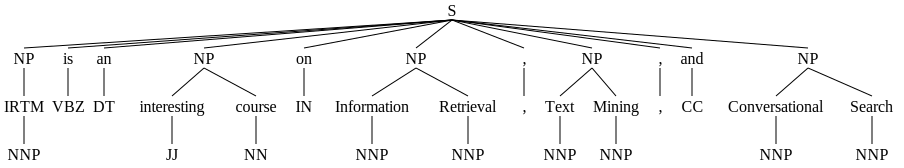

In [100]:
# Define a chunking grammar: noun phrases = zero or more adjectives followed by one or more nouns
grammar = "NP: {<JJ>*<NN.*>+}"
parser = RegexpParser(grammar)

tree = parser.parse(tagged)
tree  # svgling will render this as a tree diagram

In [101]:
# Convert tree to IOB tags
iob_tags = tree2conlltags(tree)
pprint(iob_tags)

[('IRTM', 'NNP', 'B-NP'),
 ('is', 'VBZ', 'O'),
 ('an', 'DT', 'O'),
 ('interesting', 'JJ', 'B-NP'),
 ('course', 'NN', 'I-NP'),
 ('on', 'IN', 'O'),
 ('Information', 'NNP', 'B-NP'),
 ('Retrieval', 'NNP', 'I-NP'),
 (',', ',', 'O'),
 ('Text', 'NNP', 'B-NP'),
 ('Mining', 'NNP', 'I-NP'),
 (',', ',', 'O'),
 ('and', 'CC', 'O'),
 ('Conversational', 'NNP', 'B-NP'),
 ('Search', 'NNP', 'I-NP')]


## 1.3 Named Entity Recognition with `ne_chunk`

NLTK's `ne_chunk` function performs NER by identifying named entities in POS-tagged text. It can operate in two modes:
- `binary=True` — detects named entities without classifying them
- `binary=False` — categorizes entities into types: PERSON, ORGANIZATION, GPE (Geo-Political Entity), etc.

In [ ]:
# Let's try NER on a longer, more interesting text
article = """Bill Gates is an American business magnate, software developer, and philanthropist. \
He is best known as the co-founder of Microsoft Corporation with his childhood friend Paul Allen. \
During his career at Microsoft, Gates held the positions of chairman, chief executive officer (CEO), \
president, and chief software architect, while also being the largest individual shareholder until \
May 2014. Jan Scholtes teaches a course on Information Retrieval and Text Mining at Maastricht University \
and was founder and CEO of ZyLAB Technologies amd worked as board member with Mind District. \
Today, he works as venture partner AI with Endeit Capital in Amsterdam, the Netherlands and with IPRally in Helsinki, Finland as board memner. \
In December 2023, ChatGPT became the fastest-growing consumer application, recording over 100 million users only \
two months after its launch in November 2022. ChatGPT is a natural language processing tool powered by \
GPT, which is an LLM developed by OpenAI."""

print(article[:200], "...")

Bill Gates is an American business magnate, software developer, and philanthropist. He is best known as the co-founder of Microsoft Corporation with his childhood friend Paul Allen. During his career  ...


In [103]:
# Binary NER (just detect named entities)
sentences = sent_tokenize(article)
tokenized_sents = [word_tokenize(s) for s in sentences]
tagged_sents = [pos_tag(t) for t in tokenized_sents]
chunked_sents = [ne_chunk(t, binary=True) for t in tagged_sents]

for tree in chunked_sents:
    for chunk in tree:
        if hasattr(chunk, 'label'):
            print(chunk)

(NE Bill/NNP Gates/NNP)
(NE American/JJ)
(NE Microsoft/NNP Corporation/NNP)
(NE Paul/NNP Allen/NNP)
(NE Microsoft/NNP)
(NE Gates/NNP)
(NE Jan/NNP Scholtes/NNP)
(NE Text/NNP Mining/NNP)
(NE Maastricht/NNP University/NNP)
(NE Trovit/NNP)
(NE ChatGPT/NNP)
(NE ChatGPT/NNP)
(NE GPT/NNP)
(NE OpenAI/NNP)


In [104]:
# Categorized NER (classify entity types)
chunked_sents_cat = [ne_chunk(t, binary=False) for t in tagged_sents]

for tree in chunked_sents_cat:
    for chunk in tree:
        if hasattr(chunk, 'label'):
            print(f"{chunk.label():15s} {' '.join(c[0] for c in chunk)}")

PERSON          Bill
GPE             Gates
GPE             American
ORGANIZATION    Microsoft Corporation
PERSON          Paul Allen
ORGANIZATION    Microsoft
PERSON          Gates
ORGANIZATION    CEO
PERSON          Jan
GPE             Scholtes
PERSON          Text Mining
ORGANIZATION    Maastricht University
ORGANIZATION    Textkernel
GPE             Trovit
ORGANIZATION    ChatGPT
ORGANIZATION    ChatGPT
ORGANIZATION    GPT
ORGANIZATION    LLM
ORGANIZATION    OpenAI


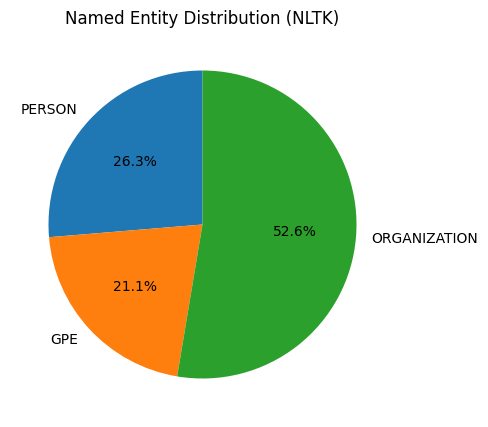

In [105]:
# Visualize entity distribution
entity_counts = defaultdict(int)
for tree in chunked_sents_cat:
    for chunk in tree:
        if hasattr(chunk, 'label'):
            entity_counts[chunk.label()] += 1

labels = list(entity_counts.keys())
sizes = list(entity_counts.values())

plt.figure(figsize=(8, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Named Entity Distribution (NLTK)")
plt.show()

**Observation:** NLTK's NER is rule-based and uses the MaxEnt classifier. While it provides a quick baseline, it misses many entities and sometimes mis-classifies them. Traditional approaches like HMM, MEMM, and CRF also struggle with long-range dependencies, ambiguity, and out-of-vocabulary words.

This motivates the use of deep learning approaches like **BERT**, which we explore next.

---
# 2. BERT: Tokenizers and Embeddings

**BERT** (Bidirectional Encoder Representations from Transformers) is a Transformer-based model that revolutionized NLP. Key properties:

- **Bidirectional context**: unlike older models (LSTMs) that read text left-to-right or stitch two directions together, BERT sees the entire sentence simultaneously using *self-attention*.
- **Contextualized embeddings**: the word "Apple" gets different vector representations depending on whether the sentence is about fruit or the company.
- **WordPiece tokenization**: handles out-of-vocabulary words by splitting them into known subword units (e.g., "HuggingFace" → ["Hugging", "##Face"]).
- **Pre-trained** on Masked Language Modeling (MLM) and Next Sentence Prediction (NSP) tasks, then **fine-tuned** for downstream tasks like NER, sentiment analysis, and question answering.

The [HuggingFace Transformers](https://huggingface.co/docs/transformers/) library provides easy access to thousands of pre-trained models.

## 2.1 Vocabulary and Tokenizers

A tokenizer converts raw text into numerical token IDs that the model can process. BERT uses a **WordPiece** tokenizer with special tokens:
- `[CLS]` — placed at the beginning of every input (used for classification tasks)
- `[SEP]` — separates sentence pairs or marks the end
- `[PAD]` — pads shorter sequences to match the longest in a batch

In [106]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize a sentence
text = "Information Retrieval and Text Mining is an exciting field."
tokenized_text = tokenizer.tokenize(text)
print("Tokens:", tokenized_text)

Tokens: ['information', 'retrieval', 'and', 'text', 'mining', 'is', 'an', 'exciting', 'field', '.']


In [107]:
# Add special tokens and convert to IDs
marked_text = ['[CLS]'] + tokenized_text + ['[SEP]']
input_ids = tokenizer.convert_tokens_to_ids(marked_text)
print("Marked tokens:", marked_text)
print("Token IDs:    ", input_ids)

Marked tokens: ['[CLS]', 'information', 'retrieval', 'and', 'text', 'mining', 'is', 'an', 'exciting', 'field', '.', '[SEP]']
Token IDs:     [101, 2592, 26384, 1998, 3793, 5471, 2003, 2019, 10990, 2492, 1012, 102]


In [108]:
# Explore the vocabulary
print("Vocab size:", len(tokenizer.vocab))
print("Sample entries (5000-5019):", list(tokenizer.vocab.keys())[5000:5020])

# Round-trip: IDs back to tokens
reconstructed = tokenizer.convert_ids_to_tokens(input_ids)
print("Reconstructed:", reconstructed)

Vocab size: 30522
Sample entries (5000-5019): ['portions', '‒', 'agent', 'amendment', '3a', '##ople', 'fielding', 'dick', '##nut', '##lining', '##100', 'ratio', 'climbs', 'ح', 'marek', 'capcom', '##tell', 'sermons', '##cius', 'remembered']
Reconstructed: ['[CLS]', 'information', 'retrieval', 'and', 'text', 'mining', 'is', 'an', 'exciting', 'field', '.', '[SEP]']


## 2.2 Getting Embeddings from BERT

BERT-base has 12 Transformer encoder layers, each producing 768-dimensional hidden states. We can extract these embeddings to understand how BERT represents words in context.

In [109]:
# Load the BERT model
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()  # set to evaluation mode

# Prepare input: "I love AI"
sentence = "I love AI"
tokens = tokenizer.tokenize(sentence)
tokens = ['[CLS]'] + tokens + ['[SEP]']

# Pad to length 7
while len(tokens) < 7:
    tokens.append('[PAD]')

# Create attention mask (1 = real token, 0 = padding)
attention_mask = [1 if t != '[PAD]' else 0 for t in tokens]

# Convert to tensor
token_ids = torch.tensor([tokenizer.convert_tokens_to_ids(tokens)])
attention_mask = torch.tensor([attention_mask])

print(f"Tokens: {tokens}")
print(f"IDs:    {token_ids[0].tolist()}")
print(f"Mask:   {attention_mask[0].tolist()}")

Loading weights: 100%|██████████| 199/199 [00:00<00:00, 948.39it/s, Materializing param=pooler.dense.weight]                               
BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Tokens: ['[CLS]', 'i', 'love', 'ai', '[SEP]', '[PAD]', '[PAD]']
IDs:    [101, 1045, 2293, 9932, 102, 0, 0]
Mask:   [1, 1, 1, 1, 1, 0, 0]


In [110]:
# Get embeddings
with torch.no_grad():
    outputs = model(token_ids, attention_mask=attention_mask)

last_hidden_state = outputs.last_hidden_state
pooler_output = outputs.pooler_output

print(f"Last hidden state shape: {last_hidden_state.shape}")  # [batch=1, seq_len=7, hidden=768]
print(f"Pooler output shape:     {pooler_output.shape}")      # [batch=1, hidden=768]
print(f"\nThe embedding for token '{tokens[3]}' (index 3) has shape: {last_hidden_state[0, 3, :].shape}")

Last hidden state shape: torch.Size([1, 7, 768])
Pooler output shape:     torch.Size([1, 768])

The embedding for token 'ai' (index 3) has shape: torch.Size([768])


## 2.3 Extracting Embeddings from All Encoder Layers

BERT-base produces 13 sets of hidden states:
- `hidden_states[0]` = initial word embedding layer (non-contextual)
- `hidden_states[1]` through `hidden_states[12]` = output of each of the 12 encoder layers

Research has shown that different layers capture different linguistic features. Concatenating or averaging specific layers can produce better results for different tasks (see Devlin et al., 2019).

In [111]:
# Reload model with output_hidden_states=True
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
model.eval()

with torch.no_grad():
    outputs = model(token_ids, attention_mask=attention_mask)

hidden_states = outputs.hidden_states
print(f"Number of hidden state layers: {len(hidden_states)}")  # 13
print(f"Shape of each layer: {hidden_states[0].shape}")         # [1, 7, 768]

Loading weights: 100%|██████████| 199/199 [00:00<00:00, 1003.48it/s, Materializing param=pooler.dense.weight]                              
BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Number of hidden state layers: 13
Shape of each layer: torch.Size([1, 7, 768])


In [112]:
# Compare embeddings from different layers for the word "AI" (index 3)
print("Comparing 'AI' embedding across layers:")
for layer_idx in [0, 1, 6, 11, 12]:
    embedding = hidden_states[layer_idx][0, 3, :]
    print(f"  Layer {layer_idx:2d}: mean={embedding.mean():.4f}, std={embedding.std():.4f}, norm={embedding.norm():.4f}")

Comparing 'AI' embedding across layers:
  Layer  0: mean=0.0038, std=0.6070, norm=16.8115
  Layer  1: mean=-0.0260, std=0.7191, norm=19.9278
  Layer  6: mean=-0.0271, std=0.7972, norm=22.0908
  Layer 11: mean=-0.0303, std=0.7294, norm=20.2185
  Layer 12: mean=-0.0104, std=0.5315, norm=14.7215


---
# 3. Pre-trained BERT for Named Entity Recognition

Instead of training a model from scratch, we can use **pre-trained NER models** from HuggingFace. The `dslim/bert-base-NER` model is a `bert-base-cased` model fine-tuned on the CoNLL-2003 dataset. It recognizes four entity types:

| Label | Entity Type |
|-------|------------|
| **PER** | Person |
| **ORG** | Organization |
| **LOC** | Location |
| **MISC** | Miscellaneous |

**Why BERT for NER?**
- **Contextualized embeddings**: "Apple" gets different representations depending on context (company vs. fruit).
- **True bidirectionality**: every layer sees every other word simultaneously via self-attention.
- **WordPiece handles OOV**: unknown words are broken into meaningful subword units.
- **Long-range dependencies**: self-attention connects words regardless of distance.

**BERT vs. LLMs (GPT-4, etc.) for production NER:**
- BERT is ~100x faster than large LLMs for tagging tasks
- BERT can run locally (privacy-preserving)
- BERT provides structured 1:1 token-to-label mapping (ideal for Knowledge Graphs)

In [113]:
# Load a pre-trained NER pipeline
ner_pipeline = pipeline("ner", model="dslim/bert-base-NER", aggregation_strategy="simple")

# Test on our article text
results = ner_pipeline(article)

# Display results in a DataFrame
df_ner = pd.DataFrame(results)
print(df_ner[['entity_group', 'word', 'score']].to_string(index=False))

Loading weights: 100%|██████████| 199/199 [00:00<00:00, 832.86it/s, Materializing param=classifier.weight]                                      
BertForTokenClassification LOAD REPORT from: dslim/bert-base-NER
Key                      | Status     |  | 
-------------------------+------------+--+-
bert.pooler.dense.weight | UNEXPECTED |  | 
bert.pooler.dense.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


entity_group                  word    score
         PER            Bill Gates 0.999711
        MISC              American 0.999516
         ORG Microsoft Corporation 0.999257
         PER            Paul Allen 0.999715
         ORG             Microsoft 0.998604
         PER                 Gates 0.997380
         PER          Jan Scholtes 0.996484
        MISC Information Retrieval 0.626202
        MISC           Text Mining 0.736828
         ORG Maastricht University 0.972060
         ORG           Text Mining 0.767020
         ORG            Textkernel 0.997044
         ORG                Trovit 0.975403
         ORG                   Cha 0.839832
         ORG                 ##GPT 0.781404
        MISC                   Cha 0.396089
        MISC                  ##GP 0.661405
        MISC                    GP 0.853827
        MISC                    LL 0.934334
         ORG                OpenAI 0.971049


In [114]:
# Compare BERT NER results with NLTK NER on the same text
print("=" * 60)
print("BERT NER Results:")
print("=" * 60)
for r in results:
    print(f"  {r['entity_group']:8s} {r['word']:30s} (score: {r['score']:.3f})")

print()
print("=" * 60)
print("NLTK NER Results (for comparison):")
print("=" * 60)
for tree in chunked_sents_cat:
    for chunk in tree:
        if hasattr(chunk, 'label'):
            entity_text = ' '.join(c[0] for c in chunk)
            print(f"  {chunk.label():15s} {entity_text}")

BERT NER Results:
  PER      Bill Gates                     (score: 1.000)
  MISC     American                       (score: 1.000)
  ORG      Microsoft Corporation          (score: 0.999)
  PER      Paul Allen                     (score: 1.000)
  ORG      Microsoft                      (score: 0.999)
  PER      Gates                          (score: 0.997)
  PER      Jan Scholtes                   (score: 0.996)
  MISC     Information Retrieval          (score: 0.626)
  MISC     Text Mining                    (score: 0.737)
  ORG      Maastricht University          (score: 0.972)
  ORG      Text Mining                    (score: 0.767)
  ORG      Textkernel                     (score: 0.997)
  ORG      Trovit                         (score: 0.975)
  ORG      Cha                            (score: 0.840)
  ORG      ##GPT                          (score: 0.781)
  MISC     Cha                            (score: 0.396)
  MISC     ##GP                           (score: 0.661)
  MISC     GP

**Observation:** BERT-based NER is significantly more accurate than NLTK's rule-based approach. BERT correctly identifies entities even in complex contexts, handles multi-word entities better, and provides confidence scores.

---
# 4. Fine-tuning BERT for Named Entity Recognition

While pre-trained NER models work well for general entities, you may need to fine-tune BERT on your own data for domain-specific NER (e.g., medical entities, legal terms, financial instruments).

Here we fine-tune BERT on the **CoNLL-2003** dataset, which contains POS tags, syntactic chunk tags, and NER tags. The NER tags use the IOB2 format with these entity types: PER, ORG, LOC, MISC.

The key difference from sequence classification:
- `BertForSequenceClassification` classifies the **entire sentence** (one label per sentence)
- `BertForTokenClassification` classifies **each token** (one label per token — needed for NER)

In [115]:
# Load the CoNLL-2003 dataset
try:
    dataset = load_dataset("conll2003")
except Exception:
    dataset = load_dataset("eriktks/conll2003")
print(dataset)

Using the latest cached version of the dataset since eriktks/conll2003 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at C:\Users\jcsch\.cache\huggingface\datasets\eriktks___conll2003\default\0.0.0\ce85b39f9dd99f552d0739d456814e95fb6a39b0 (last modified on Tue Feb 17 23:04:45 2026).


DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})


In [116]:
# Inspect dataset structure
print("Example tokens:", dataset["train"][0]["tokens"])
print("Example NER tags:", dataset["train"][0]["ner_tags"])

# Map tag indices to readable names
ner_features = dataset["train"].features["ner_tags"].feature
tag_names = ner_features.names
print("\nNER tag names:", tag_names)

# Print aligned tokens and tags
for word, tag_id in zip(dataset["train"][0]["tokens"], dataset["train"][0]["ner_tags"]):
    print(f"  {word:15s} → {tag_names[tag_id]}")

Example tokens: ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
Example NER tags: [3, 0, 7, 0, 0, 0, 7, 0, 0]

NER tag names: ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']
  EU              → B-ORG
  rejects         → O
  German          → B-MISC
  call            → O
  to              → O
  boycott         → O
  British         → B-MISC
  lamb            → O
  .               → O


## 4.1 Handling Subword Tokenization

BERT's WordPiece tokenizer may split words into subwords (e.g., "lamb" → "la", "##mb"). This creates a **mismatch** between the number of tokens and the number of labels. We need to align labels with subword tokens:

- Special tokens (`[CLS]`, `[SEP]`) get label `-100` (ignored by the loss function)
- The first subword of a word gets the original label
- Subsequent subwords of the same word also get label `-100`

In [117]:
# Load tokenizer for fine-tuning
tokenizer_ft = AutoTokenizer.from_pretrained("bert-base-uncased")

# Demonstrate the subword alignment problem
example_tokens = dataset["train"][0]["tokens"]
inputs = tokenizer_ft(example_tokens, is_split_into_words=True)
word_ids = inputs.word_ids()

print("Original tokens:", example_tokens[:8])
print("Subword IDs:    ", inputs["input_ids"][:12])
print("Word IDs:       ", word_ids[:12])

Original tokens: ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb']
Subword IDs:     [101, 7327, 19164, 2446, 2655, 2000, 17757, 2329, 12559, 1012, 102]
Word IDs:        [None, 0, 1, 2, 3, 4, 5, 6, 7, 8, None]


In [118]:
# Function to align labels with subword tokens
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id is None:
            new_labels.append(-100)  # special tokens
        elif word_id != current_word:
            current_word = word_id
            new_labels.append(labels[word_id])  # first subword gets the label
        else:
            new_labels.append(-100)  # subsequent subwords
    return new_labels

# Test alignment
example_labels = dataset["train"][0]["ner_tags"]
aligned = align_labels_with_tokens(example_labels, word_ids)
print("Original labels:", example_labels[:8])
print("Aligned labels: ", aligned[:12])

Original labels: [3, 0, 7, 0, 0, 0, 7, 0]
Aligned labels:  [-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, -100]


In [119]:
# Apply alignment to entire dataset
def align_labels(examples):
    tokenized = tokenizer_ft(examples["tokens"], truncation=True, is_split_into_words=True)
    all_labels = []
    for i, labels in enumerate(examples["ner_tags"]):
        word_ids = tokenized.word_ids(batch_index=i)
        all_labels.append(align_labels_with_tokens(labels, word_ids))
    tokenized["labels"] = all_labels
    return tokenized

tokenized_datasets = dataset.map(align_labels, batched=True, remove_columns=dataset["train"].column_names)

# Subset training data for faster training (~4000 examples → ~2-3 min on GPU)
tokenized_datasets["train"] = tokenized_datasets["train"].shuffle(seed=42).select(range(4000))
print(f"Training examples: {len(tokenized_datasets['train'])}, Validation examples: {len(tokenized_datasets['validation'])}")
print("Tokenized dataset columns:", tokenized_datasets["train"].column_names)

Training examples: 4000, Validation examples: 3250
Tokenized dataset columns: ['input_ids', 'token_type_ids', 'attention_mask', 'labels']


## 4.2 Training the NER Model

In [120]:
# Data collator: dynamically pads batches
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer_ft)

# Load evaluation metric
metric = evaluate.load("seqeval")

# Define compute_metrics function
def compute_metrics_ner(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    
    true_labels = [[tag_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [tag_names[p] for p, l in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    
    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [121]:
# Create label mappings
id2label = {i: label for i, label in enumerate(tag_names)}
label2id = {label: i for i, label in enumerate(tag_names)}

# Load model for token classification
model_ner = AutoModelForTokenClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(tag_names),
    id2label=id2label,
    label2id=label2id,
)
print(f"Model loaded with {len(tag_names)} labels: {tag_names}")

Loading weights: 100%|██████████| 197/197 [00:00<00:00, 908.03it/s, Materializing param=bert.encoder.layer.11.output.dense.weight]              
BertForTokenClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
bert.pooler.dense.weight                   | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
bert.pooler.dense.bias                     | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can

Model loaded with 9 labels: ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']


In [122]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results_ner",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_steps=50,
    save_strategy="no",
)

# Create trainer
trainer_ner = Trainer(
    model=model_ner,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    processing_class=tokenizer_ft,
    data_collator=data_collator,
    compute_metrics=compute_metrics_ner,
)

# Train (~2-3 minutes on RTX 4070 GPU with 4000 training samples)
print("Starting NER fine-tuning...")
trainer_ner.train()

Starting NER fine-tuning...


c:\Users\jcsch\OneDrive - Dennenhof Capital BV\Documents\UM\IRTM\IRTM 2025-2026\.venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.153091,0.132168,0.766869,0.828172,0.796343,0.967758


TrainOutput(global_step=250, training_loss=0.3115369300842285, metrics={'train_runtime': 529.5483, 'train_samples_per_second': 7.554, 'train_steps_per_second': 0.472, 'total_flos': 97322869677888.0, 'train_loss': 0.3115369300842285, 'epoch': 1.0})

In [123]:
# Evaluate the model
eval_results = trainer_ner.evaluate()
print("\nEvaluation Results:")
for k, v in eval_results.items():
    if isinstance(v, float):
        print(f"  {k}: {v:.4f}")


Evaluation Results:
  eval_loss: 0.1322
  eval_precision: 0.7669
  eval_recall: 0.8282
  eval_f1: 0.7963
  eval_accuracy: 0.9678
  eval_runtime: 84.9587
  eval_samples_per_second: 38.2540
  eval_steps_per_second: 2.4010
  epoch: 1.0000


---
# 5. Entity Normalization and String Matching

After extracting entities, we often need to **normalize** them — mapping different textual representations to the same entity. For example, "MSFT", "Microsoft Corp", and "Microsoft Corporation" all refer to the same organization.

**Why normalization matters:**
- Without normalization, knowledge graphs contain duplicate nodes for the same real-world entity
- The same name can be written in many forms (abbreviations, misspellings, different orderings)
- OCR errors in digitized documents create spelling variations

**Common string matching techniques:**
- **Levenshtein (edit) distance**: number of insertions, deletions, and substitutions needed
- **Jaro-Winkler similarity**: preference for matching prefixes (good for person names)
- **Jaccard coefficient**: overlap of character n-grams or token sets
- **Soft TF-IDF**: TF-IDF cosine similarity with fuzzy token matching

## 5.1 Levenshtein (Edit) Distance

The Levenshtein distance counts the minimum number of single-character edits (insertions, deletions, substitutions) needed to transform one string into another.

In [124]:
# Levenshtein distance examples
pairs = [
    ("Sony Ericsson", "Sony Ericssen"),      # one substitution
    ("Sony Ericsson", "Ericsson Sony"),       # word-order swap
    ("Microsoft", "MSFT"),                    # abbreviation
    ("Bill Gates", "William Gates"),          # name variation
    ("Maastricht", "Maastright"),             # common misspelling
    ("Jan Scholtes", "J. Scholtes"),          # abbreviated first name
]

print(f"{'String 1':25s} {'String 2':25s} {'Edit Dist':>10s} {'Ratio':>8s}")
print("-" * 70)
for s1, s2 in pairs:
    dist = Levenshtein.distance(s1, s2)
    ratio = Levenshtein.ratio(s1, s2)
    print(f"{s1:25s} {s2:25s} {dist:10d} {ratio:8.3f}")

String 1                  String 2                   Edit Dist    Ratio
----------------------------------------------------------------------
Sony Ericsson             Sony Ericssen                      1    0.923
Sony Ericsson             Ericsson Sony                     10    0.615
Microsoft                 MSFT                               8    0.154
Bill Gates                William Gates                      4    0.783
Maastricht                Maastright                         1    0.900
Jan Scholtes              J. Scholtes                        2    0.870


## 5.2 Jaro-Winkler Similarity

Jaro-Winkler similarity gives a preference to strings that match from the beginning. This makes it particularly suitable for **person names** and **company names** where the beginning of the string is most informative.

In [125]:
# Jaro-Winkler similarity
print(f"{'String 1':25s} {'String 2':25s} {'Jaro':>8s} {'Jaro-Wink':>10s}")
print("-" * 70)
for s1, s2 in pairs:
    jaro = Levenshtein.jaro(s1, s2)
    jaro_winkler = Levenshtein.jaro_winkler(s1, s2)
    print(f"{s1:25s} {s2:25s} {jaro:8.3f} {jaro_winkler:10.3f}")

String 1                  String 2                      Jaro  Jaro-Wink
----------------------------------------------------------------------
Sony Ericsson             Sony Ericssen                0.949      0.969
Sony Ericsson             Ericsson Sony                0.776      0.776
Microsoft                 MSFT                         0.454      0.454
Bill Gates                William Gates                0.827      0.827
Maastricht                Maastright                   0.933      0.960
Jan Scholtes              J. Scholtes                  0.914      0.923


## 5.3 Jaccard Coefficient

The Jaccard coefficient measures the overlap between two sets. For string matching, we can use **character n-grams** (commonly bigrams) as the set elements:

$$J(A, B) = \frac{|A \cap B|}{|A \cup B|}$$

This approach is also related to **Dice's coefficient** and **Q-gram distance**.

In [126]:
# Jaccard coefficient using character bigrams
def char_bigrams(s):
    """Generate character bigrams from a string."""
    s = s.lower()
    return set(s[i:i+2] for i in range(len(s) - 1))

def jaccard_bigram(s1, s2):
    """Compute Jaccard coefficient using character bigrams."""
    bg1 = char_bigrams(s1)
    bg2 = char_bigrams(s2)
    intersection = bg1 & bg2
    union = bg1 | bg2
    return len(intersection) / len(union) if union else 0.0

print(f"{'String 1':25s} {'String 2':25s} {'Jaccard':>10s}")
print("-" * 62)
for s1, s2 in pairs:
    j = jaccard_bigram(s1, s2)
    print(f"{s1:25s} {s2:25s} {j:10.3f}")

String 1                  String 2                     Jaccard
--------------------------------------------------------------
Sony Ericsson             Sony Ericssen                  0.833
Sony Ericsson             Ericsson Sony                  0.667
Microsoft                 MSFT                           0.100
Bill Gates                William Gates                  0.500
Maastricht                Maastright                     0.636
Jan Scholtes              J. Scholtes                    0.615


## 5.4 Comparing String Matching Methods

Different methods work better for different types of text:
- **Jaro-Winkler** is best for names (prefers matching beginnings)
- **Levenshtein** is good for detecting typos and OCR errors
- **Jaccard** is robust to word-order changes and partial overlaps
- **Soft TF-IDF** combines TF-IDF weighting with fuzzy matching (best for record linkage)

In practice, combining multiple methods in a **voting algorithm** often yields the best results (see Cohen, Ravikumar & Fienberg, 2003).

In [127]:
# Summary comparison table
print(f"{'Pair':55s} {'Levenshtein':>12s} {'Jaro-Wink':>10s} {'Jaccard':>10s}")
print("-" * 90)
for s1, s2 in pairs:
    lev = Levenshtein.ratio(s1, s2)
    jw = Levenshtein.jaro_winkler(s1, s2)
    jac = jaccard_bigram(s1, s2)
    print(f"{s1 + ' vs ' + s2:55s} {lev:12.3f} {jw:10.3f} {jac:10.3f}")

Pair                                                     Levenshtein  Jaro-Wink    Jaccard
------------------------------------------------------------------------------------------
Sony Ericsson vs Sony Ericssen                                 0.923      0.969      0.833
Sony Ericsson vs Ericsson Sony                                 0.615      0.776      0.667
Microsoft vs MSFT                                              0.154      0.454      0.100
Bill Gates vs William Gates                                    0.783      0.827      0.500
Maastricht vs Maastright                                       0.900      0.960      0.636
Jan Scholtes vs J. Scholtes                                    0.870      0.923      0.615


---
# 6. From Text to Knowledge Graphs

A **Knowledge Graph** represents knowledge as concepts and the relationships between them (facts). It uses a graph-structured data model where:
- **Nodes** represent entities (people, organizations, locations, etc.)
- **Edges** represent relationships between entities

**The 4-Step Pipeline** for building Knowledge Graphs from text:
1. **Co-reference Resolution** — resolve pronouns and other references to their referents
2. **Named Entity Recognition & Normalization** — identify and normalize entities
3. **Relationship Extraction** — identify relationships between entities
4. **Knowledge Graph Construction** — build the graph from extracted triples

**Open Information Extraction (OIE)** extracts structured triples of the form *(subject, predicate, object)* from text. These triples directly form the edges of a knowledge graph.

Knowledge Graphs are used by search engines (Google, Bing), question-answering systems (WolframAlpha, Siri), and social networks (LinkedIn, Facebook). They support better relation extraction, disambiguation, and conversational search.

## 6.1 Extracting Triples with spaCy-style Dependency Parsing

We can extract simple subject-verb-object triples from text using dependency parsing. Here we demonstrate a simple rule-based approach.

In [128]:
# Simple triple extraction using NLTK POS tags
# This is a simplified approach - production systems use dependency parsers

def extract_triples_simple(text):
    """Extract simple (subject, relation, object) triples from text using POS patterns."""
    triples = []
    sentences = sent_tokenize(text)
    
    for sent in sentences:
        tokens = word_tokenize(sent)
        tagged = pos_tag(tokens)
        
        # Simple pattern: find NNP sequences separated by verbs
        entities = []
        current_entity = []
        
        for word, tag in tagged:
            if tag.startswith('NNP'):
                current_entity.append(word)
            else:
                if current_entity:
                    entities.append(' '.join(current_entity))
                    current_entity = []
        if current_entity:
            entities.append(' '.join(current_entity))
        
        # Create co-occurrence relations between entities in the same sentence
        for i in range(len(entities)):
            for j in range(i + 1, len(entities)):
                triples.append((entities[i], "co-occurs with", entities[j]))
    
    return triples

# Extract triples from our article
triples = extract_triples_simple(article)
print(f"Extracted {len(triples)} triples:\n")
for s, p, o in triples[:15]:
    print(f"  ({s}, {p}, {o})")

Extracted 37 triples:

  (Microsoft Corporation, co-occurs with, Paul Allen)
  (Microsoft, co-occurs with, Gates)
  (Microsoft, co-occurs with, CEO)
  (Microsoft, co-occurs with, May)
  (Gates, co-occurs with, CEO)
  (Gates, co-occurs with, May)
  (CEO, co-occurs with, May)
  (Jan Scholtes, co-occurs with, Information Retrieval)
  (Jan Scholtes, co-occurs with, Text Mining)
  (Jan Scholtes, co-occurs with, Maastricht University)
  (Jan Scholtes, co-occurs with, Text)
  (Jan Scholtes, co-occurs with, Textkernel)
  (Jan Scholtes, co-occurs with, Trovit)
  (Information Retrieval, co-occurs with, Text Mining)
  (Information Retrieval, co-occurs with, Maastricht University)


## 6.2 Building and Visualizing a Knowledge Graph

We can use **NetworkX** to build a graph from extracted triples and visualize the entity co-occurrence network.

In [129]:
# Build a knowledge graph from the extracted triples
G = nx.Graph()

for subject, predicate, obj in triples:
    G.add_edge(subject, obj, relation=predicate)

print(f"Knowledge Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
print(f"\nNodes: {list(G.nodes())[:15]}...")

Knowledge Graph: 19 nodes, 37 edges

Nodes: ['Microsoft Corporation', 'Paul Allen', 'Microsoft', 'Gates', 'CEO', 'May', 'Jan Scholtes', 'Information Retrieval', 'Text Mining', 'Maastricht University', 'Text', 'Textkernel', 'Trovit', 'December', 'ChatGPT']...


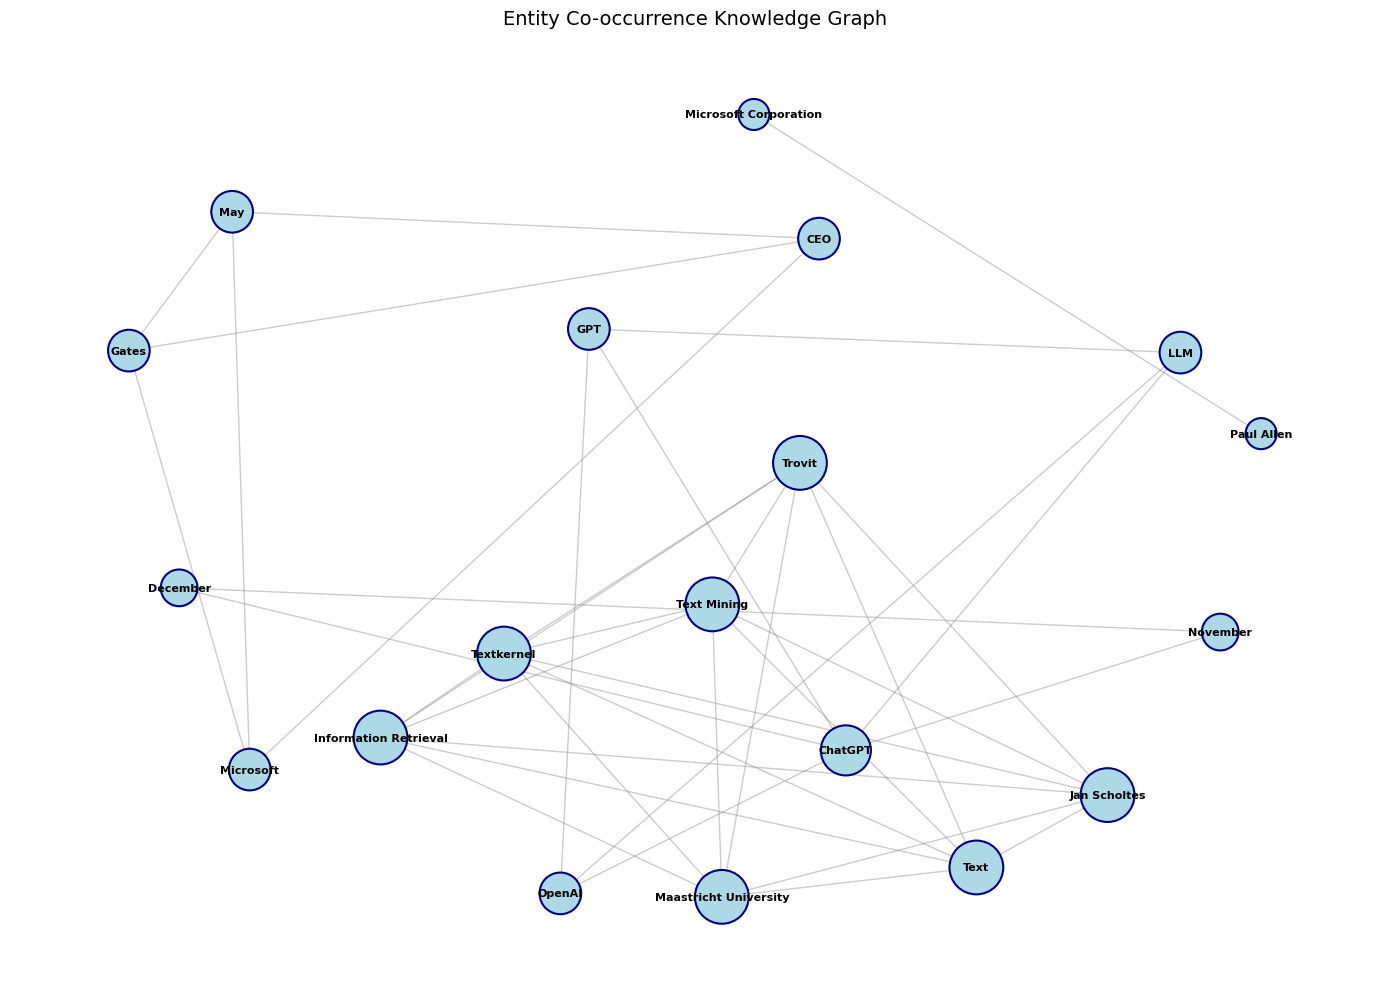

In [130]:
# Visualize the knowledge graph
plt.figure(figsize=(14, 10))

# Use spring layout for positioning
pos = nx.spring_layout(G, k=2, seed=42)

# Node sizes based on degree (connectivity)
node_sizes = [300 + 200 * G.degree(node) for node in G.nodes()]

# Draw the graph
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='lightblue', edgecolors='navy', linewidths=1.5)
nx.draw_networkx_edges(G, pos, alpha=0.4, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

plt.title("Entity Co-occurrence Knowledge Graph", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

## 6.3 Using BERT NER for Better Knowledge Graphs

We can improve our knowledge graph by using BERT-based NER to identify entities more accurately, and then build the graph from those entities.

BERT Knowledge Graph: 18 nodes, 30 edges


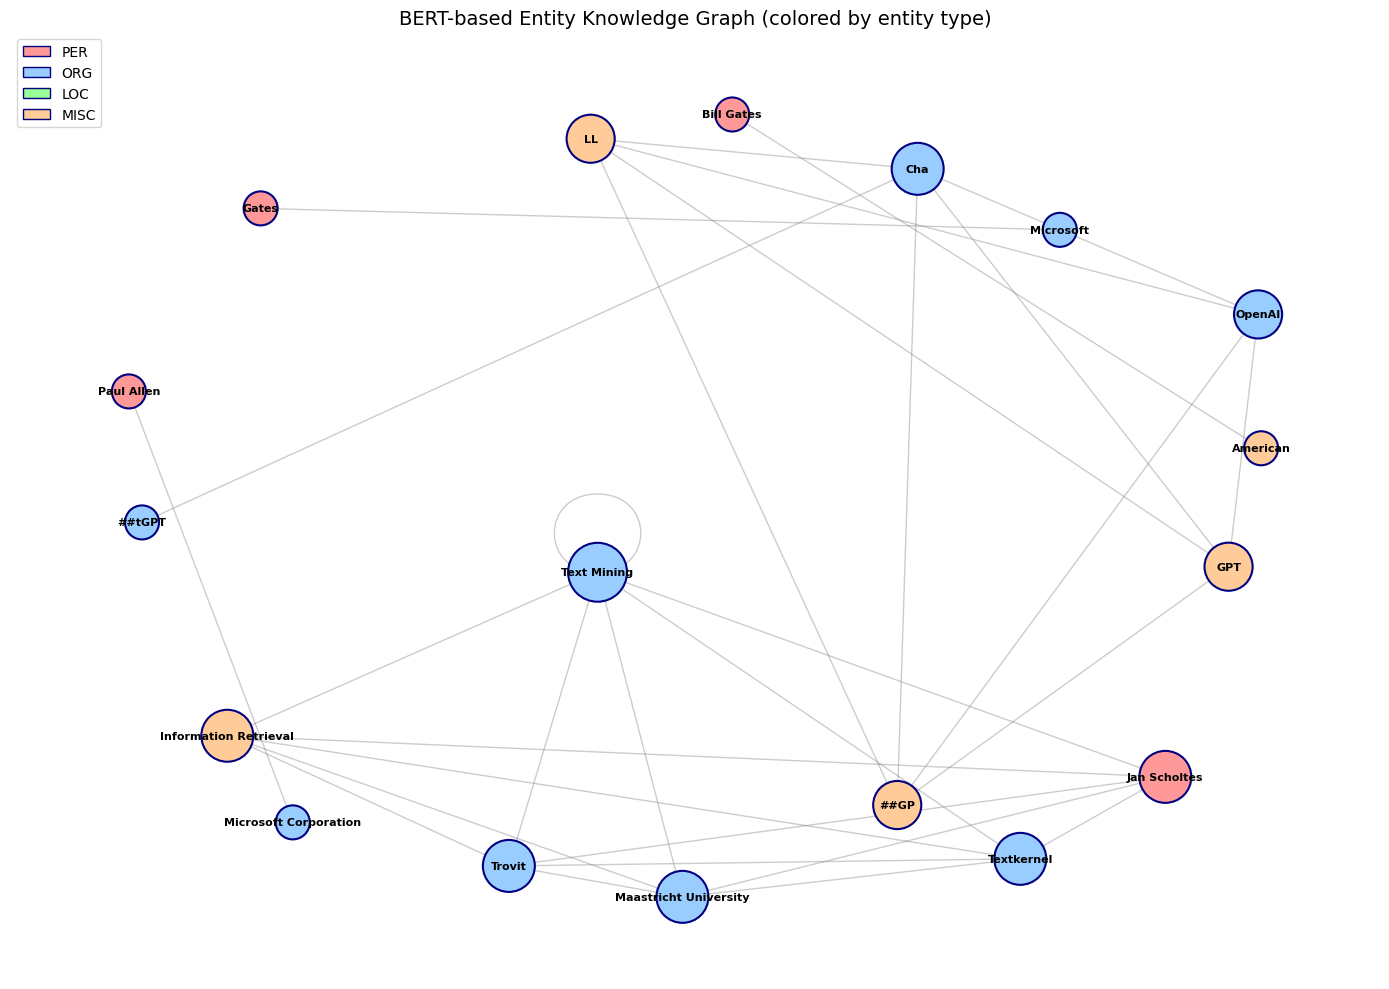

In [131]:
# Use BERT NER results to build a typed knowledge graph
G_bert = nx.Graph()

# Group NER results by sentence
sentences = sent_tokenize(article)
for sent in sentences:
    sent_ner = ner_pipeline(sent)
    entities_in_sent = [(r['word'], r['entity_group']) for r in sent_ner]
    
    # Add typed nodes
    for word, etype in entities_in_sent:
        G_bert.add_node(word, entity_type=etype)
    
    # Connect entities within the same sentence
    for i in range(len(entities_in_sent)):
        for j in range(i + 1, len(entities_in_sent)):
            G_bert.add_edge(entities_in_sent[i][0], entities_in_sent[j][0])

print(f"BERT Knowledge Graph: {G_bert.number_of_nodes()} nodes, {G_bert.number_of_edges()} edges")

# Color nodes by entity type
color_map = {'PER': '#ff9999', 'ORG': '#99ccff', 'LOC': '#99ff99', 'MISC': '#ffcc99'}
node_colors = [color_map.get(G_bert.nodes[n].get('entity_type', ''), '#dddddd') for n in G_bert.nodes()]

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G_bert, k=2.5, seed=42)
node_sizes = [400 + 200 * G_bert.degree(node) for node in G_bert.nodes()]

nx.draw_networkx_nodes(G_bert, pos, node_size=node_sizes, node_color=node_colors, edgecolors='navy', linewidths=1.5)
nx.draw_networkx_edges(G_bert, pos, alpha=0.4, edge_color='gray')
nx.draw_networkx_labels(G_bert, pos, font_size=8, font_weight='bold')

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=c, edgecolor='navy', label=t) for t, c in color_map.items()]
plt.legend(handles=legend_elements, loc='upper left', fontsize=10)

plt.title("BERT-based Entity Knowledge Graph (colored by entity type)", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

## 6.4 Searching Knowledge Graphs

Once built, knowledge graphs can be queried using:
- **Cypher** (Neo4j) — for high-performance pattern matching and traversals in property graphs
- **SPARQL** (RDF) — for semantic queries over triple stores following web standards

For example, in Cypher:
```
MATCH (p:Person)-[:WORKS_FOR]->(o:Organization)
RETURN p.name, o.name
```

And in SPARQL:
```sparql
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
SELECT ?name ?email
WHERE {
    ?person a foaf:Person .
    ?person foaf:name ?name .
    ?person foaf:mbox ?email .
}
```

**Key difference:** Neo4j/Cypher excels at deep multi-hop traversals, while RDF/SPARQL is better for linking knowledge across diverse data sources.

In the upcoming lectures on **RAG (Retrieval-Augmented Generation)**, we will see how knowledge graphs combined with vector search can significantly improve conversational search and reduce LLM hallucinations.

---
# Exercises

The following exercises are graded. Please provide your answers in the designated cells below.

## Exercise 1 — NER: Traditional vs. BERT (5 points)

Compare traditional Named Entity Recognition approaches (HMM, CRF) with BERT-based approaches. In your answer, address the following:

1. What are the main limitations of traditional approaches (HMM, CRF) for NER?
2. How does BERT's architecture (bidirectional self-attention, WordPiece tokenization) address these limitations?
3. Why might traditional approaches still be preferred in certain production scenarios?

Write your answer in the cell below (minimum 150 words).

BEGIN SOLUTION

END SOLUTION

YOUR ANSWER HERE

## Exercise 2 — Knowledge Graphs from Text (5 points)

Describe the 4-step pipeline for building Knowledge Graphs from unstructured text. In your answer, address:

1. Explain each of the four steps: Co-reference Resolution, NER & Normalization, Relationship Extraction, and KG Construction.
2. What role does entity normalization play? Give an example of how failing to normalize entities can lead to a fragmented knowledge graph.
3. How can pre-trained BERT models improve each step of this pipeline?

Write your answer in the cell below (minimum 150 words).

BEGIN SOLUTION

END SOLUTION

YOUR ANSWER HERE

## Exercise 3 — Fine-tune BERT for POS Tagging (10 points)

Adapt the NER fine-tuning code from Section 4 to fine-tune `bert-base-uncased` on **POS tagging** instead of NER. The CoNLL-2003 dataset contains POS tags in addition to NER tags.

Your task:
1. Load the CoNLL-2003 dataset and use the `pos_tags` column instead of `ner_tags`
2. Create the label alignment function for POS tags
3. Fine-tune the model for 2 epochs
4. Evaluate and report precision, recall, F1-score, and accuracy

Write your code in the cell below.

BEGIN SOLUTION

END SOLUTION

In [132]:
# YOUR CODE HERE
raise NotImplementedError("Replace this line with your solution")

NotImplementedError: Replace this line with your solution

In [ ]:
# Autograder test cell — do not modify
# This cell checks that your model has been trained and produces predictions
assert 'model_pos' in dir() or 'trainer_pos' in dir(), "You need to create a model or trainer for POS tagging"
print("Basic check passed. Your solution will be manually reviewed for correctness.")